In [1]:
import pandas as pd
import numpy as np
import random
from joblib import dump, load
from sklearn import svm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import statistics

In [2]:
features = pd.read_pickle('data/features_develop.pickle')

Delivery info is appended after purchase - it makes no sense to take those columns as features because prediction about conversion takes place before purchase. Same with products_bought column.

In [3]:
def train_and_test(df: pd.DataFrame, preprocess, runs=1, silent=False):
    scores = []
    for i in range(runs):
        train, test = train_test_split(df, test_size=0.3)
        for func in preprocess:
            train = func(train)
            test = func(test)
        test = test.assign(**{str(c): False for c in list(train.columns) if c not in set(test.columns)})
        clf = svm.SVC()
        y_col = 'made_purchase'
        x_cols = train.drop(y_col, axis=1).columns
        clf.fit(train[x_cols], train[y_col])
        correct = test[y_col] == clf.predict(test[x_cols])
        scores.append(correct.sum() / len(correct))
    score = statistics.mean(scores)
    if not silent:
        print(f'The score of model B is {round(score, 4)}')
    return score

This function will be used to quickly calculate score of our model.

# Preprocessing

In [4]:
features.dtypes

made_purchase               bool
events_count               int64
views                      int64
total_duration           float64
mean_duration            float64
products_viewed            int64
mean_time_per_product    float64
user_id                  float64
female                      bool
product_ids               object
weekday_cos              float64
weekday_sin              float64
hour_cos                 float64
hour_sin                 float64
cat_0                     object
cat_1                     object
cat_2                     object
cat_3                     object
syntetic_duration           bool
dtype: object

Feature matrix contains mostly real number or integer values but there are some non numerical types that we must take care of.

## Label encoding

Our dataset contains categorical features that must be encoded.

In [5]:
objects = features.select_dtypes(include=['object']).columns
features[objects].head()

,product_ids,cat_0,cat_1,cat_2,cat_3
13164,"{1288.0, 1284.0, 1293.0, 1286.0}",{sprzęt rtv},{video},{telewizory i akcesoria},{anteny rtv}
30418,"{1077.0, 1078.0}",{komputery},{drukarki i skanery},{biurowe urządzenia wielofunkcyjne},{nan}
25999,"{1004.0, 1005.0, 1008.0, 1012.0, 1013.0}",{gry i konsole},{gry na konsole},{gry xbox 360},{nan}
26835,"{1032.0, 1034.0, 1037.0, 1038.0, 1039.0, 1017.0}",{komputery},{monitory},{monitory lcd},{nan}
5998,"{1080.0, 1002.0, 1076.0, 1079.0}",{komputery},{drukarki i skanery},{biurowe urządzenia wielofunkcyjne},{nan}


Because those columns are sets of categories, there are at least two ways we can encode them.

### One hot encoding

In [6]:
def encode_one_hot(df):
    objects = df.select_dtypes(include=['object']).columns
    encoded_objects = []
    for col in objects:
        encoded_objects.append(pd.get_dummies(df[col].apply(str)))
    return pd.concat([df.drop(objects, axis=1)] + encoded_objects, axis=1)

In [7]:
one_hot = encode_one_hot(features)
one_hot.shape

(23595, 3584)

In [8]:
# train_and_test(features.reset_index(drop=True), [encode_one_hot]) (takes very long)

After performing one hot encoding on columns that are sets of labels we've got many more features - those could be reduced if we encoded the presence of any particular category with a boolean flag. That would drastically improve training and testing time as it takes more than 15 mins to do so using one-hot-encoded data.

### Multi hot encoding

Multi hot encoding means creating one column per category and setting boolean flag as True if a set of labels contains it. This also means that one value (set of labels) is mapped to boolean vector that could potentially have more than one flag set to True. This property makes sense in case of additivity - set of one label plus another label equals two labels (same with boolean columns) and leads to fewer features in outcomig dataset. We will try and create another DataFrame, this time using the second technique.

In [9]:
def multi_hot_encoder(s: pd.Series):
    result = pd.DataFrame(index=s.index)
    numpy_data = pd.DataFrame(s.apply(list).tolist()).to_numpy()
    clean = numpy_data[np.logical_not(pd.isna(numpy_data))]
    unique = np.unique(clean)    
    for c in unique:
        result[c] = s.apply(lambda r: c in r)
    return result

In [10]:
def encode_multi_hot(df):
    objects = df.select_dtypes(include=['object']).columns
    encoded_objects = []
    for col in objects:
        encoded_objects.append(multi_hot_encoder(df[col]))
    multi_hot = df.drop(objects, axis=1)
    return pd.concat([multi_hot] + encoded_objects, axis=1)    

In [11]:
multi_hot = encode_multi_hot(features)
multi_hot.shape

(23595, 115)

That method returned an encoded dataset with as few as 115 features.

In [12]:
train_and_test(features.reset_index(drop=True), [encode_multi_hot])

The score of model B is 0.7484


0.7484107924848142

Dataset created with multi hot encoding technique takes less time to process and gives really promissing results. We will use it in further preprocessing processes.

In [13]:
preprocessing = [encode_multi_hot]

## User id

User id although a number can not be treated as one. In this case we use one hot encoding to encode its possible values.

In [14]:
def one_hot_user(df):
    return pd.concat([df.drop('user_id', axis=1), pd.get_dummies(df.user_id, prefix='', prefix_sep='')], axis=1) 

In [15]:
user_id_encoded = one_hot_user(features)
user_id_encoded.shape

(23595, 218)

In [16]:
train_and_test(features.reset_index(drop=True), preprocessing + [one_hot_user])

The score of model B is 0.7402


0.7402175448509677

As presented above, the overall score of our model improved after user id encoding.

In [17]:
preprocessing = [encode_multi_hot, one_hot_user]

## Scaling

In [18]:
def normalize_numeric(df):
    numeric = df.select_dtypes(include=['int64', 'float64']).columns
    scaled_numeric = (df[numeric] - df[numeric].mean()) / df[numeric].std()
    scaled = df.drop(numeric, axis=1)
    return pd.concat([scaled, scaled_numeric], axis=1).reset_index(drop=True)

In [19]:
scaled = normalize_numeric(features)
scaled.shape

(23595, 19)

In [20]:
train_and_test(features.reset_index(drop=True), preprocessing + [normalize_numeric])

The score of model B is 0.8104


0.8104252012996186

Normalization helped with our classification problem and now the final score is a bit higher.

In [21]:
preprocessing = [encode_multi_hot, one_hot_user, normalize_numeric]

# Feature selection

After dataset encoding now it's time to select only those features that are most informative. Deleting unwanted noise-producing columns will speed up calculations and improve overall model score.

In [22]:
preprocessed = features
for func in preprocessing:
    preprocessed = func(preprocessed)
preprocessed.shape

(23595, 314)

In [23]:
train, test = train_test_split(features, test_size=0.3)
for func in preprocessing:
    train = func(train)
    test = func(test)
test = test.assign(**{str(c): False for c in list(train.columns) if c not in set(test.columns)})

## Correlation

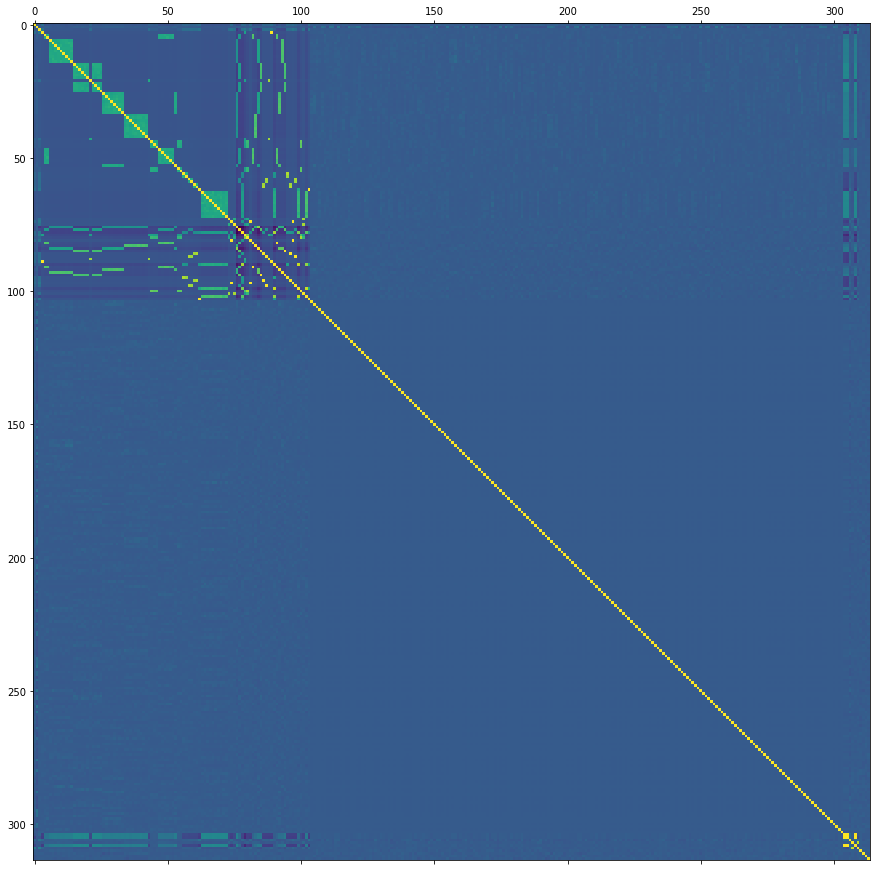

In [24]:
f = plt.figure(figsize=(15, 15))
plt.matshow(preprocessed.corr(), fignum=f.number)
plt.show()

This plot shows us that there are features that are not really helpful with our problem. Deleting them will not only speed up learning/predicting processes but also can lead to better performance and scores. Further analysis will be based on mutual information and correlation of the columns in our dataset.

## Mutual information / correlation table

In [25]:
columns = preprocessed.columns.to_series()
mutual_info = columns.apply(lambda c: metrics.mutual_info_score(preprocessed[c], preprocessed.made_purchase))
corr = preprocessed.corr().made_purchase
information = pd.DataFrame(data={'mi': mutual_info, 'co': corr.abs(), 'both': mutual_info * corr.abs()})
information.sort_values(by='both', ascending=False)

,mi,co,both
made_purchase,6.356588e-01,1.000000,6.356588e-01
mean_time_per_product,1.536475e-01,0.182529,2.804514e-02
total_duration,6.150541e-02,0.067414,4.146333e-03
mean_duration,9.210130e-02,0.018990,1.749003e-03
views,1.391631e-02,0.115357,1.605350e-03
...,...,...,...
280.0,2.380520e-07,0.000691,1.644986e-10
158.0,2.143614e-07,0.000656,1.405357e-10
244.0,8.386454e-08,0.000409,3.431578e-11
127.0,1.044320e-08,0.000144,1.508956e-12


Having this information, now it's time to test most promissing subsets of features and pick the best result in terms of overall model score.

## Testing features

In [26]:
def test_features(indicator: pd.Series):
    results = pd.DataFrame(columns=['features', 'score'])
    for f in range(len(indicator), 2, -100):
        best = indicator.nlargest(f).index
        clf = svm.SVC()
        y_col = 'made_purchase'
        x_cols = [c for c in train.drop(y_col, axis=1).columns if c in best]
        clf.fit(train[x_cols], train[y_col])
        correct = test[y_col] == clf.predict(test[x_cols])
        score = correct.sum() / len(correct)
        results = results.append({'count': int(f-1), 'score': score, 'features': best}, ignore_index=True)
    return results

### Based on mutual information and correlation

In [27]:
results_both = test_features(information.both)
results_both.sort_values(by='score', ascending=False).head(2)

,features,score,count
0,"Index([ 'made_purchase', 'mean_time_per...",0.808589,313.0
3,"Index([ 'made_purchase', 'mean_time_per...",0.791213,13.0


### Based on correlation

In [28]:
results_co = test_features(information.co)
results_co.sort_values(by='score', ascending=False).head(2)

,features,score,count
0,"Index([ 'made_purchase', 'mean_time_per...",0.808589,313.0
1,"Index([ 'made_purchase', 'mean_time_p...",0.789377,213.0


### Based on mutual information

In [29]:
results_mi = test_features(information.mi)
results_mi.sort_values(by='score', ascending=False).head(2)

,features,score,count
0,"Index([ 'made_purchase', 'mean_time_per...",0.808589,313.0
3,"Index([ 'made_purchase', 'mean_time_per...",0.791213,13.0


## Comparison

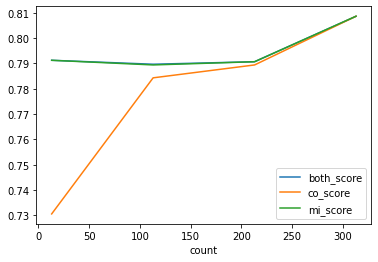

In [30]:
res = []
res.append(results_both[['count']])
res.append(results_both[['score']].add_prefix('both_'))
res.append(results_co[['score']].add_prefix('co_'))
res.append(results_mi[['score']].add_prefix('mi_'))
pd.concat(res, axis=1).plot(x='count', y=['both_score', 'co_score', 'mi_score'])

In [31]:
all_results = pd.concat([results_both, results_co, results_mi], axis=0).reset_index()
best_result = all_results.loc[all_results.score.idxmax()]
best_result = best_result.append(pd.Series(['made_purchase'], index=['y']))
print(f'Best results obtained with {int(best_result["count"])} features')
best_features = preprocessed[best_result.features]
preprocessing = [encode_multi_hot, normalize_numeric, lambda df: df[[c for c in best_result.features if c in df.columns]]]

Best results obtained with 313 features


# Final training

In [32]:
final_train = pd.read_pickle('data/features_develop.pickle')
for func in preprocessing:
    final_train = func(final_train)
y_col = 'made_purchase'
clf = svm.SVC()
clf.fit(final_train.drop(y_col, axis=1), final_train[y_col])

SVC()

# Final testing

In [33]:
final_testing = pd.read_pickle('data/features_prod.pickle')
for func in preprocessing:
    final_testing = func(final_testing)
final_testing.assign(**{c: False for c in list(final_train.columns) if c not in set(final_testing.columns)})
y_col = 'made_purchase'
correct = final_testing[y_col] == clf.predict(final_testing.drop(y_col, axis=1))
score = correct.sum() / len(correct)
print(f'The final score of model B is {round(score, 4)}')

The final score of model B is 0.8069


# Saving model

In [34]:
dump(clf, 'data/model_b.joblib') 
best_result.to_pickle('data/model_b_metadata.pickle')
preprocessed[best_result.features].describe().to_pickle('data/model_b_data.pickle')